# Transfer learning with Tensorflow part 3: Scaling up

## Create helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-10 07:19:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-10 07:19:37 (93.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
#Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## 101 Food Classes: working with less data

In [3]:
# Get data (10% of 10 food classes from Food101)
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

#Unzip the download file
unzip_data('101_food_classes_10_percent.zip')

#Create training and test directory paths
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2022-08-10 07:19:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  61.0MB/s    in 27s     

2022-08-10 07:20:08 (57.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
# How many images/classes are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/poutine'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/crab_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/

In [5]:
#Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode='categorical',
                                                                           batch_size = BATCH_SIZE)
test_data= tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size = BATCH_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to buld data augmentation right into the model
* Build a headless (no top layers) functional EfficientNetB0 backbone-model
* Compile our model
* Feature extract for 5 full passes

In [6]:
checkpoint_path = "101_food_classes_10_percent_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [7]:
# Create data augmentation layer to incorporate it right into the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255), #Keep for models like ResNet50V2 but EfficientNet's having rescaling build-in
], name='data_augmentation')

In [8]:
#Setup input shape and base model, freezing the base model layers
input_shape = (224, 224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

#Add in data augmentation Sequential model as a layer 
x = data_augmentation(inputs)

#Give base model, the inputs (after augmentation ) and dont't train it
x=base_model(x, training=False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

#Put a dense layer on as the output
x = layers.Dense(20, activation="relu", name="dense_1")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

#Make a model using the inputs and outputs
model = keras.Model(inputs, outputs)



16719872/16705208 [==============================] - 0s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense_1 (Dense)             (None, 20)                25620     
                                                                 
 output_layer (Dense)        (None, 101)               2121  

In [10]:

#9. Compile the model
model.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics =["accuracy"])

#10. Fit the model and save its history
history_all_classes_10_percent = model.fit(train_data_all_10_percent, 
                                 epochs = 5,
                                 steps_per_epoch=len(train_data_all_10_percent),
                                 validation_data=test_data,
                                 validation_steps = int(0.15* len(test_data)),
                                 callbacks = [checkpoint_callback]
                                 )

Epoch 1/5
237/237 [==============================] - 96s 329ms/step - loss: 4.3053 - accuracy: 0.0692 - val_loss: 3.7610 - val_accuracy: 0.1192
Epoch 2/5
237/237 [==============================] - 70s 294ms/step - loss: 3.3475 - accuracy: 0.2189 - val_loss: 3.0391 - val_accuracy: 0.2466
Epoch 3/5
237/237 [==============================] - 56s 232ms/step - loss: 2.8719 - accuracy: 0.3042 - val_loss: 2.7581 - val_accuracy: 0.3035
Epoch 4/5
237/237 [==============================] - 50s 210ms/step - loss: 2.6215 - accuracy: 0.3500 - val_loss: 2.5706 - val_accuracy: 0.3369
Epoch 5/5
237/237 [==============================] - 52s 217ms/step - loss: 2.4702 - accuracy: 0.3827 - val_loss: 2.4893 - val_accuracy: 0.3509


In [11]:
#Evaluate on the whole dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 61s 78ms/step - loss: 2.2509 - accuracy: 0.4110


[2.2509350776672363, 0.4109703004360199]

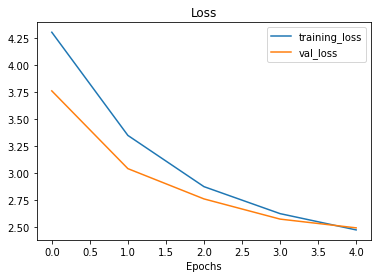

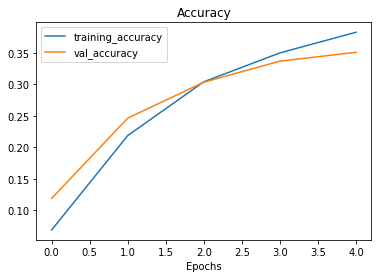

In [12]:
plot_loss_curves(history_all_classes_10_percent)

# Fine-tuning

In [13]:
#Unfreeze all of the layers in the base model
base_model.trainable = True

#Refreeze everylayer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainbae = False

In [14]:
#Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr=0.0001),
                metrics =["accuracy"])

fine_tuning_epochs = 10

#10. Fit the model and save its history
history_all_classes = model.fit(train_data_all_10_percent, 
                                 epochs = fine_tuning_epochs,
                                 initial_epoch= history_all_classes_10_percent.epoch[-1],
                                 steps_per_epoch=len(train_data_all_10_percent),
                                 validation_data=test_data,
                                 validation_steps = int(0.15* len(test_data)),
                                 callbacks = [checkpoint_callback]
                                 )

Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


237/237 [==============================] - 210s 831ms/step - loss: 2.2134 - accuracy: 0.4294 - val_loss: 2.2240 - val_accuracy: 0.4168
Epoch 6/10
237/237 [==============================] - 161s 672ms/step - loss: 1.8818 - accuracy: 0.5053 - val_loss: 2.0953 - val_accuracy: 0.4457
Epoch 7/10
237/237 [==============================] - 147s 619ms/step - loss: 1.6206 - accuracy: 0.5642 - val_loss: 2.0079 - val_accuracy: 0.4762
Epoch 8/10
237/237 [==============================] - 141s 590ms/step - loss: 1.3854 - accuracy: 0.6217 - val_loss: 2.2448 - val_accuracy: 0.4338
Epoch 9/10
237/237 [==============================] - 137s 579ms/step - loss: 1.1668 - accuracy: 0.6709 - val_loss: 2.2622 - val_accuracy: 0.4558
Epoch 10/10
237/237 [==============================] - 127s 535ms/step - loss: 0.9938 - accuracy: 0.7195 - val_loss: 2.4292 - val_accuracy: 0.4439


In [15]:
#Evaluate on the whole dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 60s 76ms/step - loss: 2.0782 - accuracy: 0.5127


[2.0782296657562256, 0.5127128958702087]

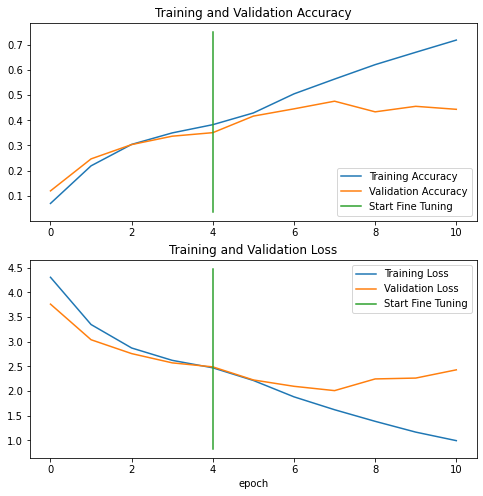

In [16]:
#Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history= history_all_classes)

## Saving and loading our model

In [17]:
# Save our fine-tuning model
model.save("drive/MyDrive/Tensorflow Developer Certificate Course/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow Developer Certificate Course/101_food_classes_10_percent_saved_big_dog_model/assets


In [18]:
#Load an evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/Tensorflow Developer Certificate Course/101_food_classes_10_percent_saved_big_dog_model")

In [19]:
#Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 69s 85ms/step - loss: 2.0782 - accuracy: 0.5127


[2.0782296657562256, 0.5127128958702087]

### Evalating the performance of the big dog model across all different classes

In [20]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip



--2022-08-10 07:47:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.130.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  26.8MB/s    in 1.7s    

2022-08-10 07:47:10 (26.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [21]:
#Unzip the download file
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')



In [22]:
#Load  in saved model
model = tf.keras.models.load_model("drive/MyDrive/Tensorflow Developer Certificate Course/101_food_classes_10_percent_saved_big_dog_model")

## Making predictions with our trained model

In [23]:
#Make predictions with model
preds_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 69s 85ms/step


In [23]:
result

In [24]:
#Get the pred classes of each label
pred_classes = preds_probs.argmax(axis =1)

In [25]:
#To get our test labels we need to unravel our test_data BatchDataset
y_labels  = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

## Evaluating our model's predictions

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred= pred_classes)
sklearn_accuracy

0.5127128712871287

## Let's get visual: making a confusion matrix

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools


# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()


  ###Change (plot  x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

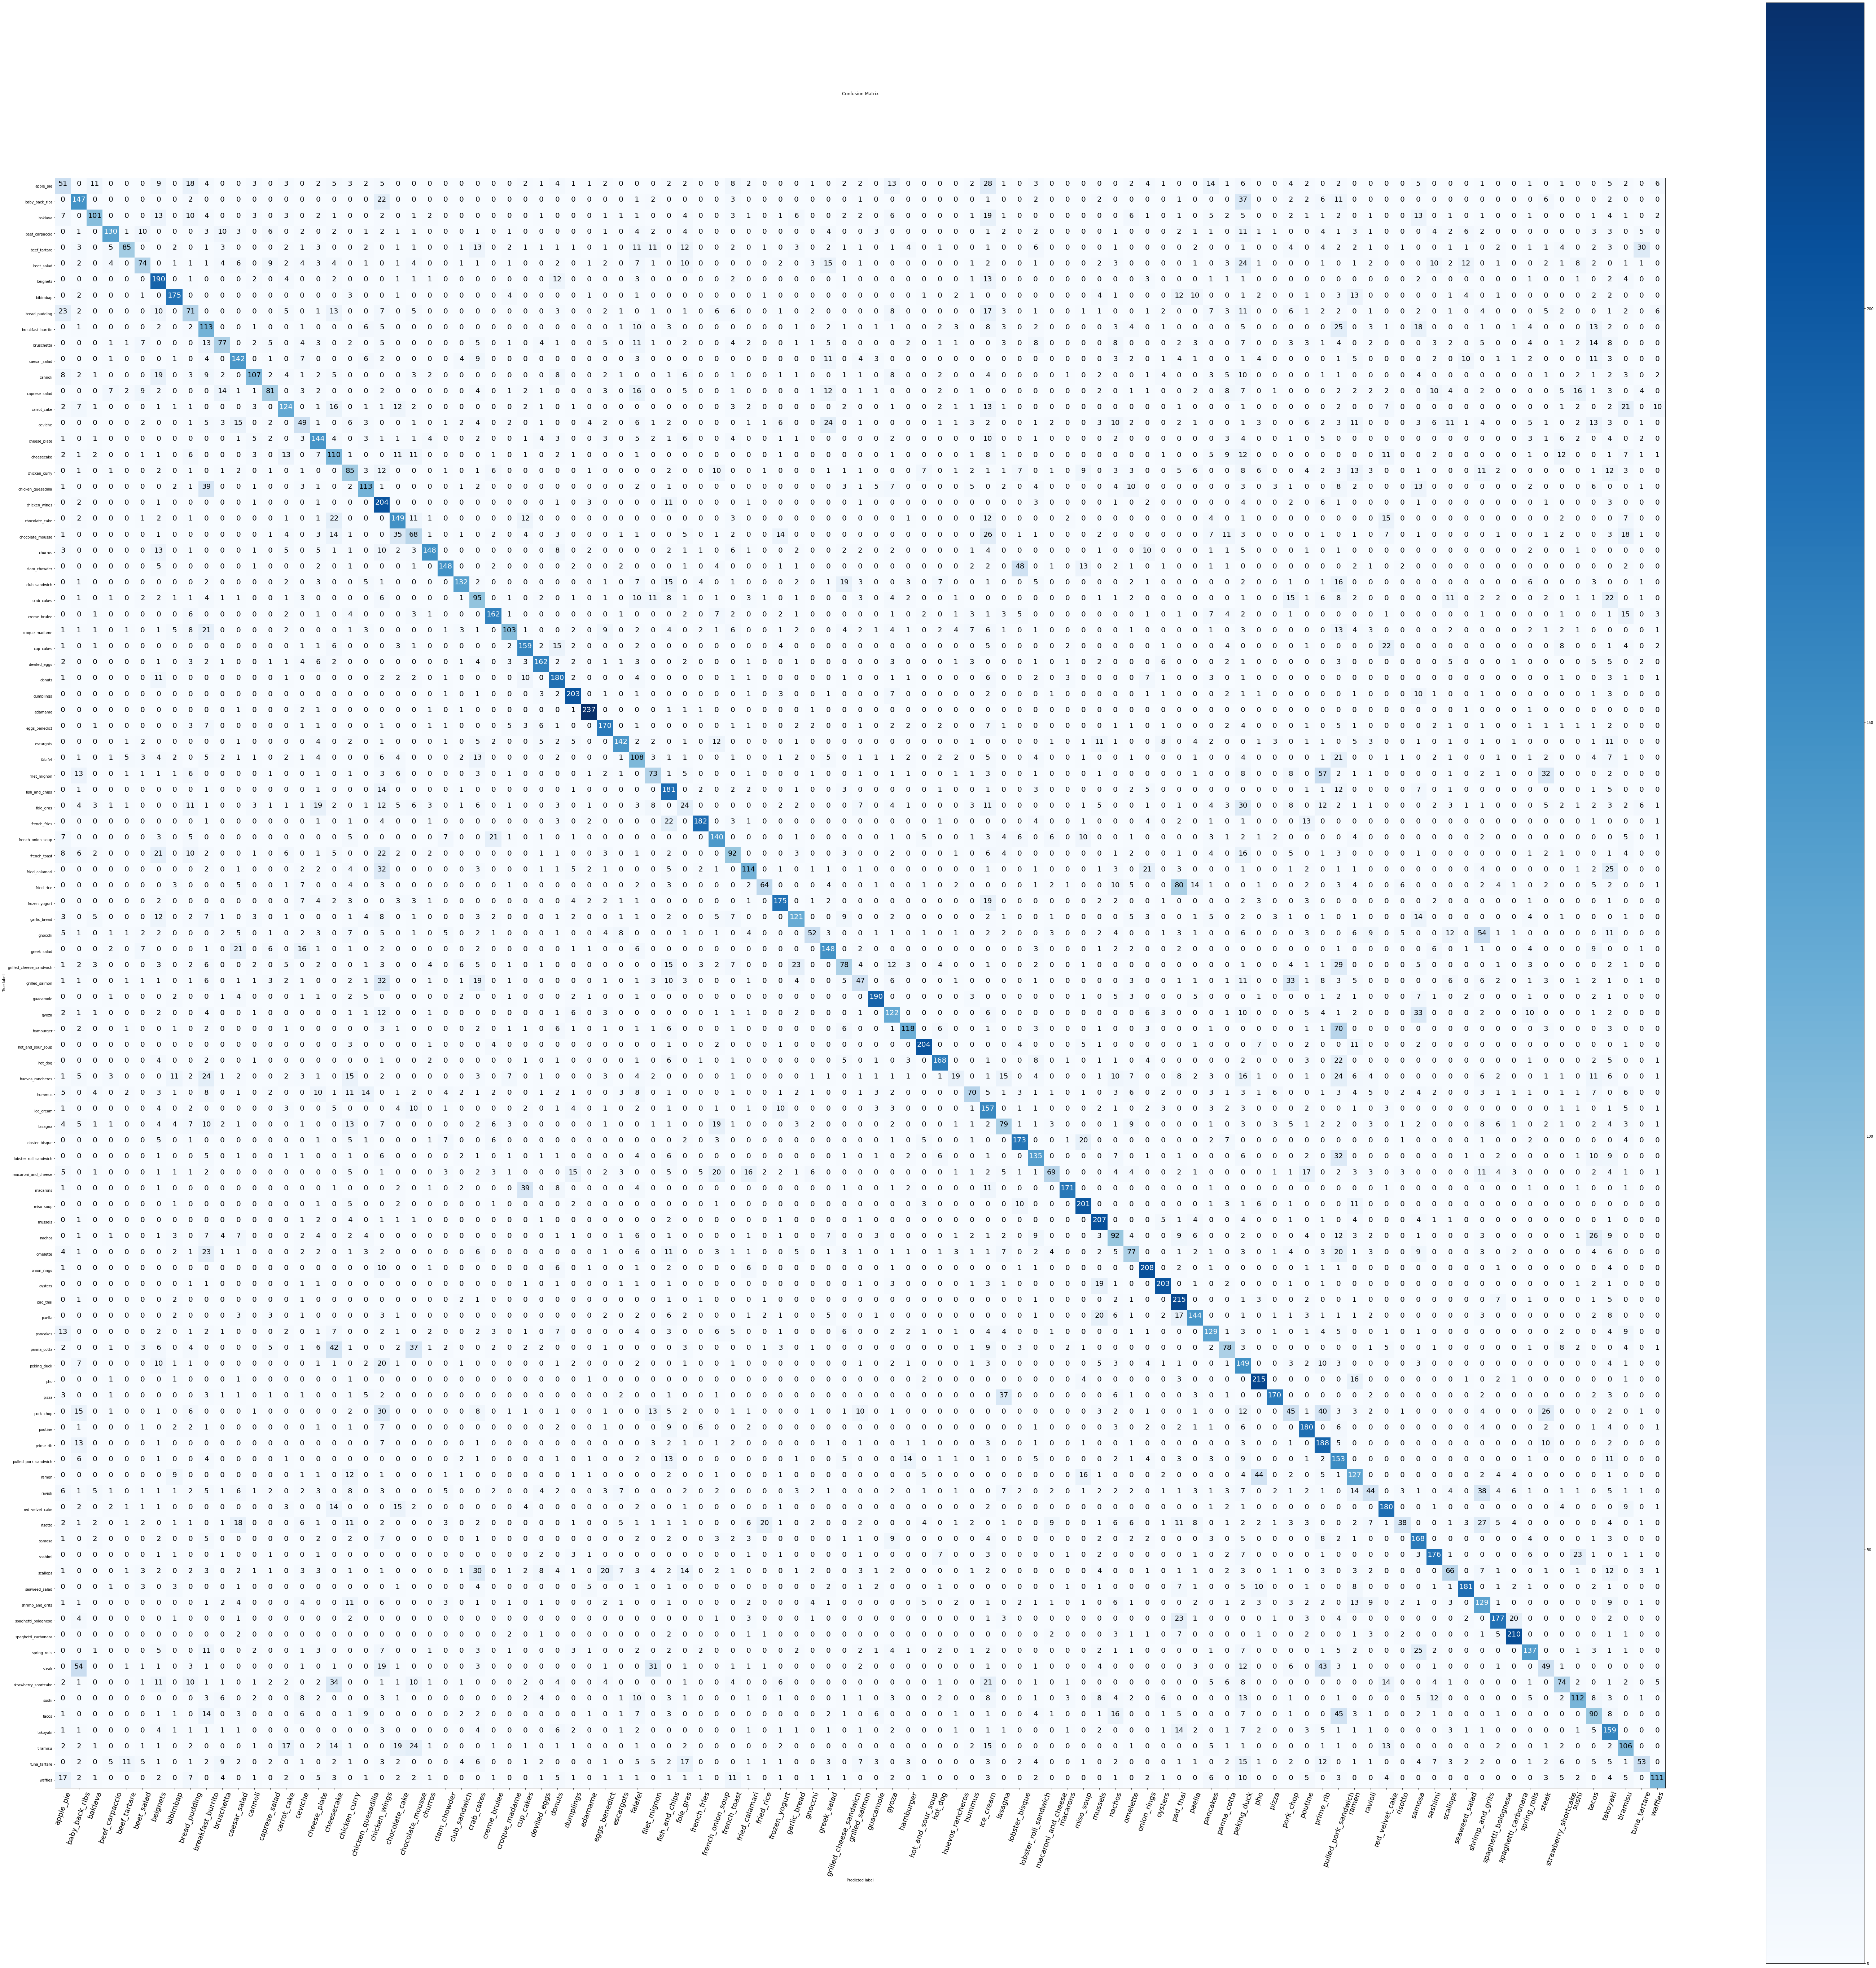

In [31]:
make_confusion_matrix(y_true = y_labels,
                     y_pred= pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size = 20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                     y_pred= pred_classes))

              precision    recall  f1-score   support

           0       0.25      0.20      0.22       250
           1       0.44      0.59      0.50       250
           2       0.66      0.40      0.50       250
           3       0.75      0.52      0.61       250
           4       0.72      0.34      0.46       250
           5       0.51      0.30      0.37       250
           6       0.46      0.76      0.57       250
           7       0.71      0.70      0.71       250
           8       0.30      0.28      0.29       250
           9       0.28      0.45      0.34       250
          10       0.49      0.31      0.38       250
          11       0.53      0.57      0.55       250
          12       0.68      0.43      0.53       250
          13       0.57      0.32      0.41       250
          14       0.54      0.50      0.52       250
          15       0.28      0.20      0.23       250
          16       0.48      0.58      0.53       250
          17       0.32    

In [34]:
#Get a dictionary of the classification report
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_true = y_labels,
                     y_pred= pred_classes,
                     output_dict= True)
classification_report_dict

{'0': {'f1-score': 0.22417582417582418,
  'precision': 0.24878048780487805,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5025641025641026,
  'precision': 0.4388059701492537,
  'recall': 0.588,
  'support': 250},
 '10': {'f1-score': 0.37745098039215685,
  'precision': 0.4873417721518987,
  'recall': 0.308,
  'support': 250},
 '100': {'f1-score': 0.5375302663438256,
  'precision': 0.6809815950920245,
  'recall': 0.444,
  'support': 250},
 '11': {'f1-score': 0.5472061657032755,
  'precision': 0.5278810408921933,
  'recall': 0.568,
  'support': 250},
 '12': {'f1-score': 0.5257985257985257,
  'precision': 0.6815286624203821,
  'recall': 0.428,
  'support': 250},
 '13': {'f1-score': 0.41326530612244905,
  'precision': 0.5704225352112676,
  'recall': 0.324,
  'support': 250},
 '14': {'f1-score': 0.5155925155925155,
  'precision': 0.5367965367965368,
  'recall': 0.496,
  'support': 250},
 '15': {'f1-score': 0.2300469483568075,
  'precision': 0.2784090909090909,
  'recall': 0.196,

### Let's plot all of our classes F1-scores

In [35]:
#Create empty dictionary
class_f1_score = {}
#Loop through classification report dictionary items
for k,v in classification_report_dict.items():
  if k == "accuracy": #stop once we get tot accuray key
    break;
  else:
    class_f1_score[test_data.class_names[int(k)]] =  v["f1-score"]
class_f1_score

{'apple_pie': 0.22417582417582418,
 'baby_back_ribs': 0.5025641025641026,
 'baklava': 0.501240694789082,
 'beef_carpaccio': 0.6132075471698112,
 'beef_tartare': 0.46195652173913043,
 'beet_salad': 0.3746835443037975,
 'beignets': 0.5714285714285715,
 'bibimbap': 0.7056451612903226,
 'bread_pudding': 0.29218106995884774,
 'breakfast_burrito': 0.3429438543247345,
 'bruschetta': 0.37745098039215685,
 'caesar_salad': 0.5472061657032755,
 'cannoli': 0.5257985257985257,
 'caprese_salad': 0.41326530612244905,
 'carrot_cake': 0.5155925155925155,
 'ceviche': 0.2300469483568075,
 'cheese_plate': 0.526508226691042,
 'cheesecake': 0.37225042301184436,
 'chicken_curry': 0.3300970873786408,
 'chicken_quesadilla': 0.5011086474501109,
 'chicken_wings': 0.4744186046511628,
 'chocolate_cake': 0.5437956204379562,
 'chocolate_mousse': 0.28997867803837957,
 'churros': 0.6757990867579908,
 'clam_chowder': 0.6636771300448431,
 'club_sandwich': 0.6125290023201857,
 'crab_cakes': 0.3505535055350554,
 'creme_br

In [37]:
#Turn f1-score into dta frame for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_score.keys()),
                         "fi-score": list(class_f1_score.values())}).sort_values("fi-score", ascending=False)

In [38]:
f1_scores

,class_names,fi-score
33,edamame,0.908046
91,spaghetti_carbonara,0.823529
54,hot_and_sour_soup,0.817635
69,oysters,0.791423
51,guacamole,0.786749
...,...,...
15,ceviche,0.230047
0,apple_pie,0.224176
77,pork_chop,0.206897
56,huevos_rancheros,0.123779


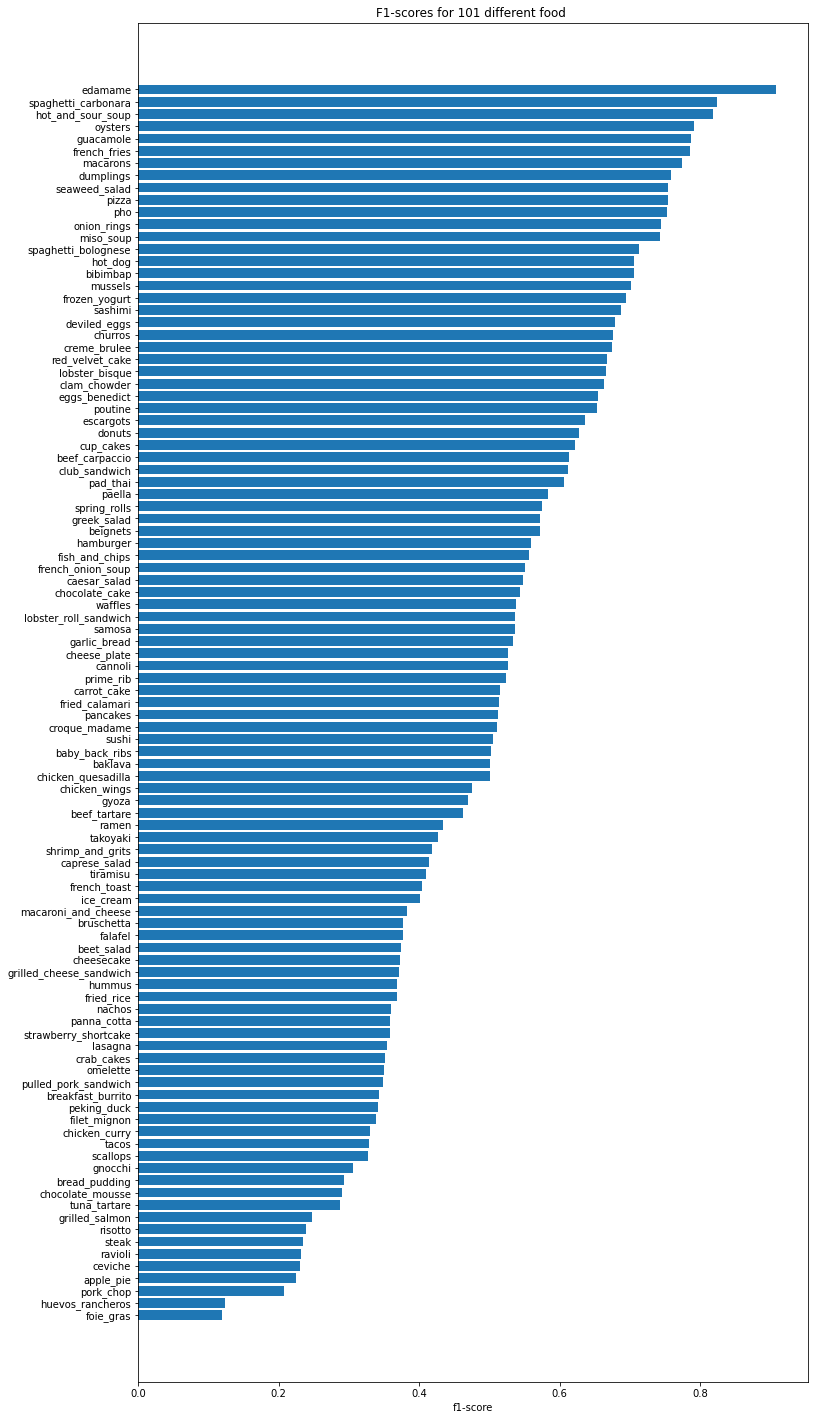

In [45]:
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["fi-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("f1-score")
ax.set_title("F1-scores for 101 different food ")
ax.invert_yaxis()

## Visualizing predictions on custom images

In [46]:
#Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale = True):
  #Read in the image
  img = tf.io.read_file(filename)

  #Decode image to tensor
  img = tf.io.decode_image(img, channels=3)

  #Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  return img

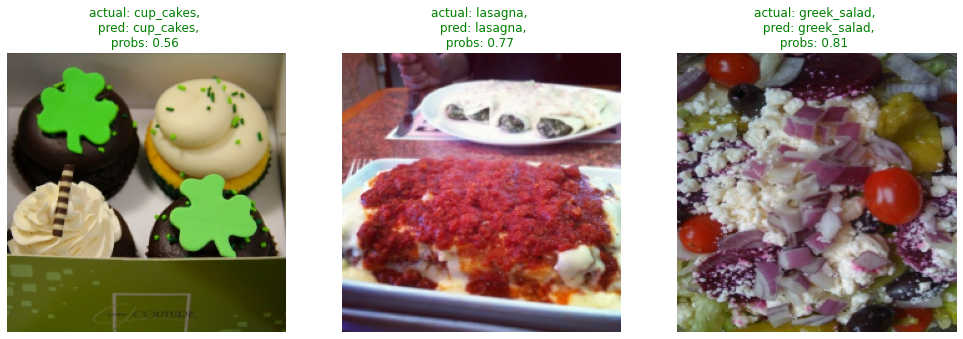

In [54]:
#Make preds on a series of random images
import os 
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(test_data.class_names)
  filename = random.choice(os.listdir(test_dir+"/"+ class_name))
  filepath = test_dir+"/"+ class_name + "/" + filename

  img = load_and_prep_image(filepath, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = test_data.class_names[pred_prob.argmax()]

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, \n pred: {pred_class},\n probs:{pred_prob.max() : .2f}  ", c = title_color)
  plt.axis('off')





### Finding the most wrong predictions

We'll go through the following steps:
1. Get all of the image file paths in the test dataset using the [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
  * **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [55]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [56]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [test_data.class_names[i] for i in y_labels],
                        "y_pred_classname": [test_data.class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.555442,apple_pie,gyoza
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.905062,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,97,0.697834,apple_pie,takoyaki
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,38,0.489552,apple_pie,fish_and_chips
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,58,0.911149,apple_pie,ice_cream


In [57]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.555442,apple_pie,gyoza,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.905062,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,97,0.697834,apple_pie,takoyaki,False
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,38,0.489552,apple_pie,fish_and_chips,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,58,0.911149,apple_pie,ice_cream,False


In [58]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
5849,b'101_food_classes_10_percent/test/churros/254...,23,68,0.999891,churros,onion_rings,False
10847,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.999885,fried_calamari,onion_rings,False
17897,b'101_food_classes_10_percent/test/paella/2986...,71,65,0.999819,paella,mussels,False
13842,b'101_food_classes_10_percent/test/hot_dog/213...,55,68,0.999700,hot_dog,onion_rings,False
10854,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.999655,fried_calamari,onion_rings,False
10774,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.999655,fried_calamari,onion_rings,False
17825,b'101_food_classes_10_percent/test/paella/1877...,71,65,0.999585,paella,mussels,False
5998,b'101_food_classes_10_percent/test/churros/952...,23,68,0.999422,churros,onion_rings,False
3203,b'101_food_classes_10_percent/test/cannoli/384...,12,6,0.999405,cannoli,beignets,False
13112,b'101_food_classes_10_percent/test/gyoza/27415...,52,32,0.999301,gyoza,dumplings,False


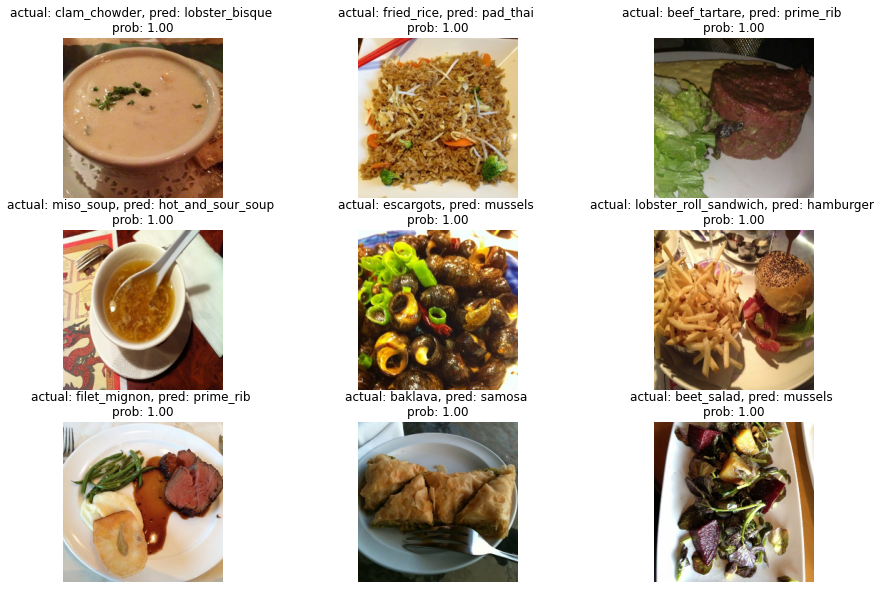

In [59]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)